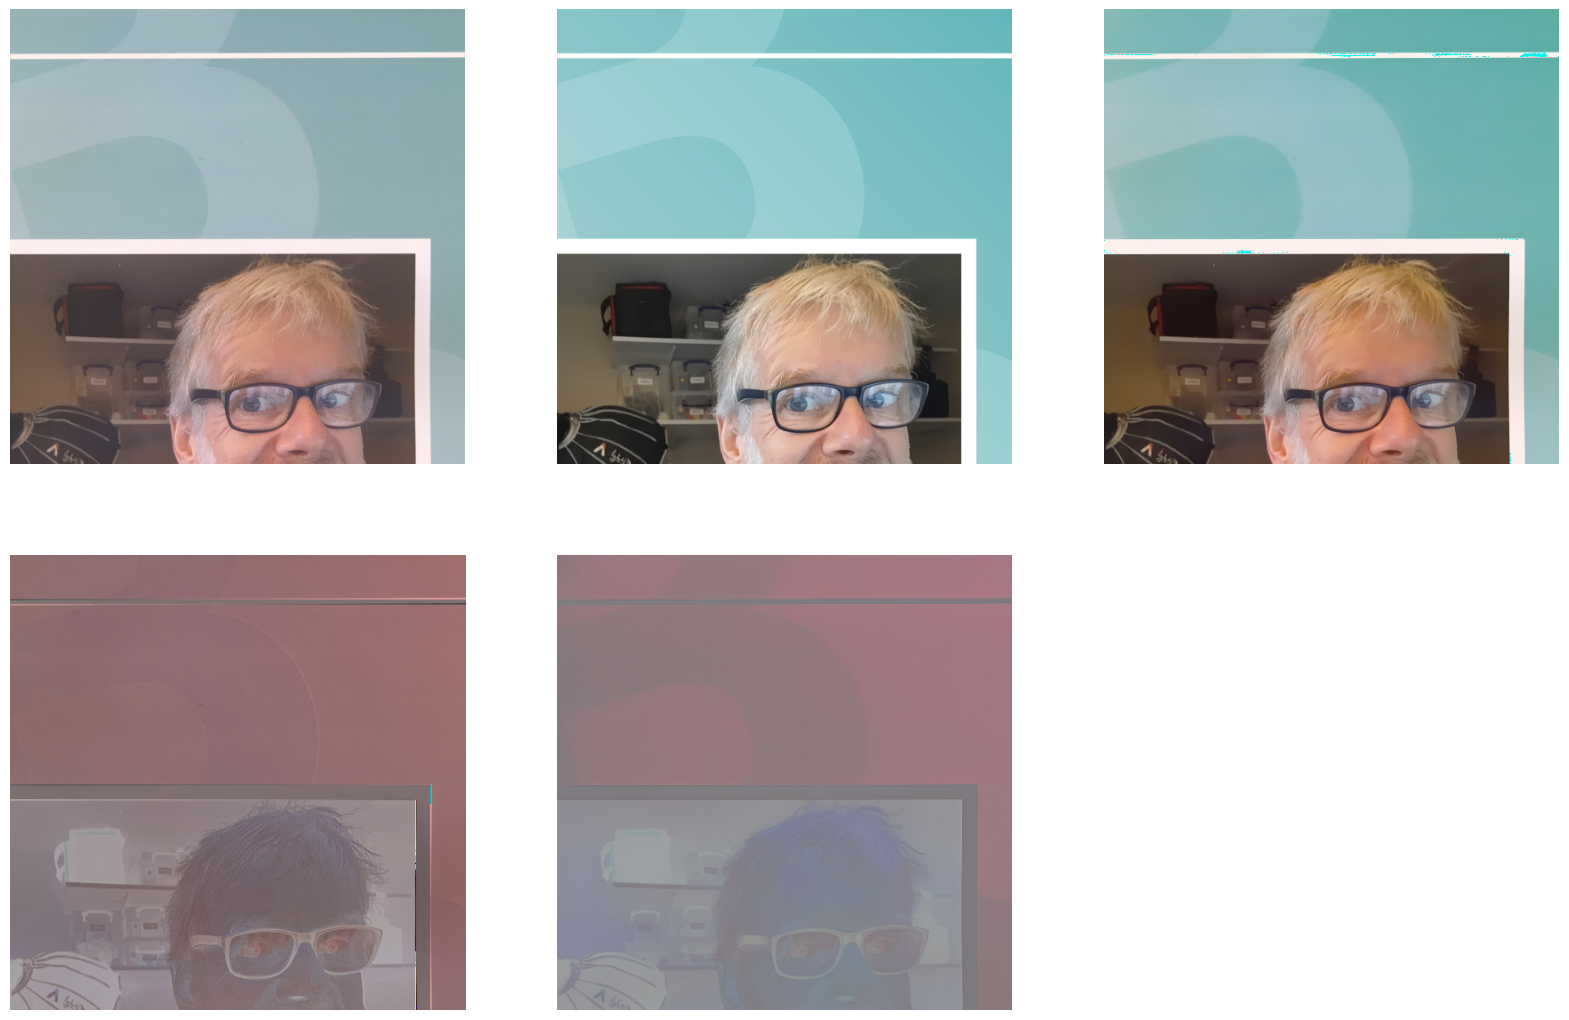

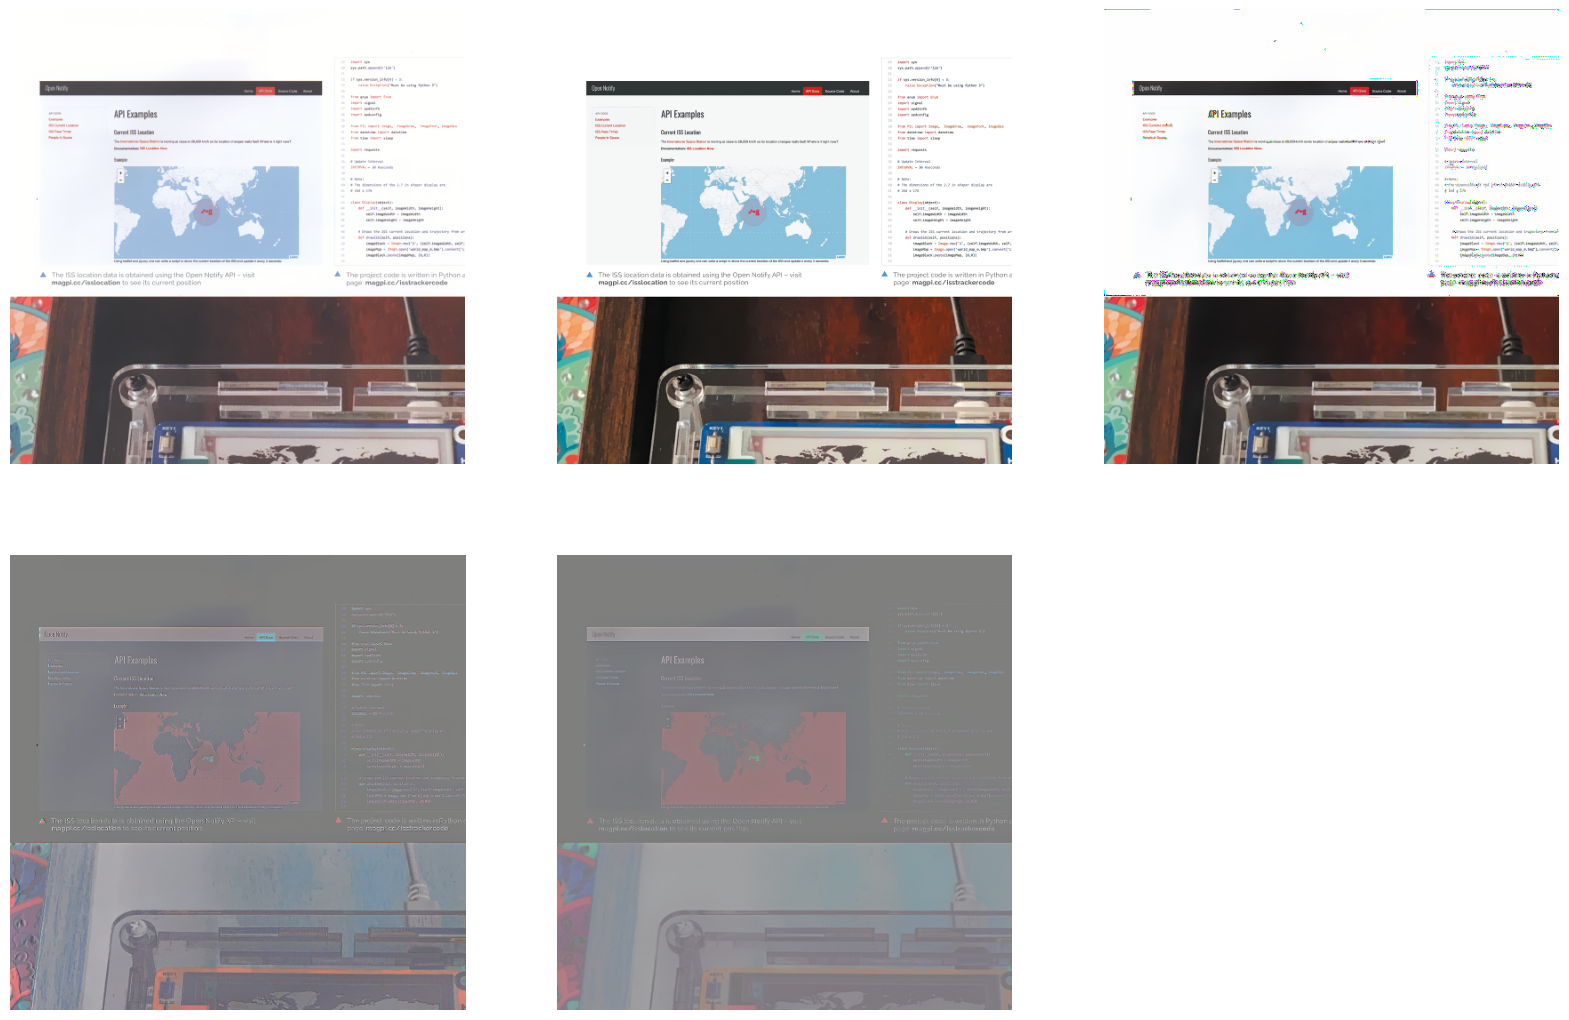

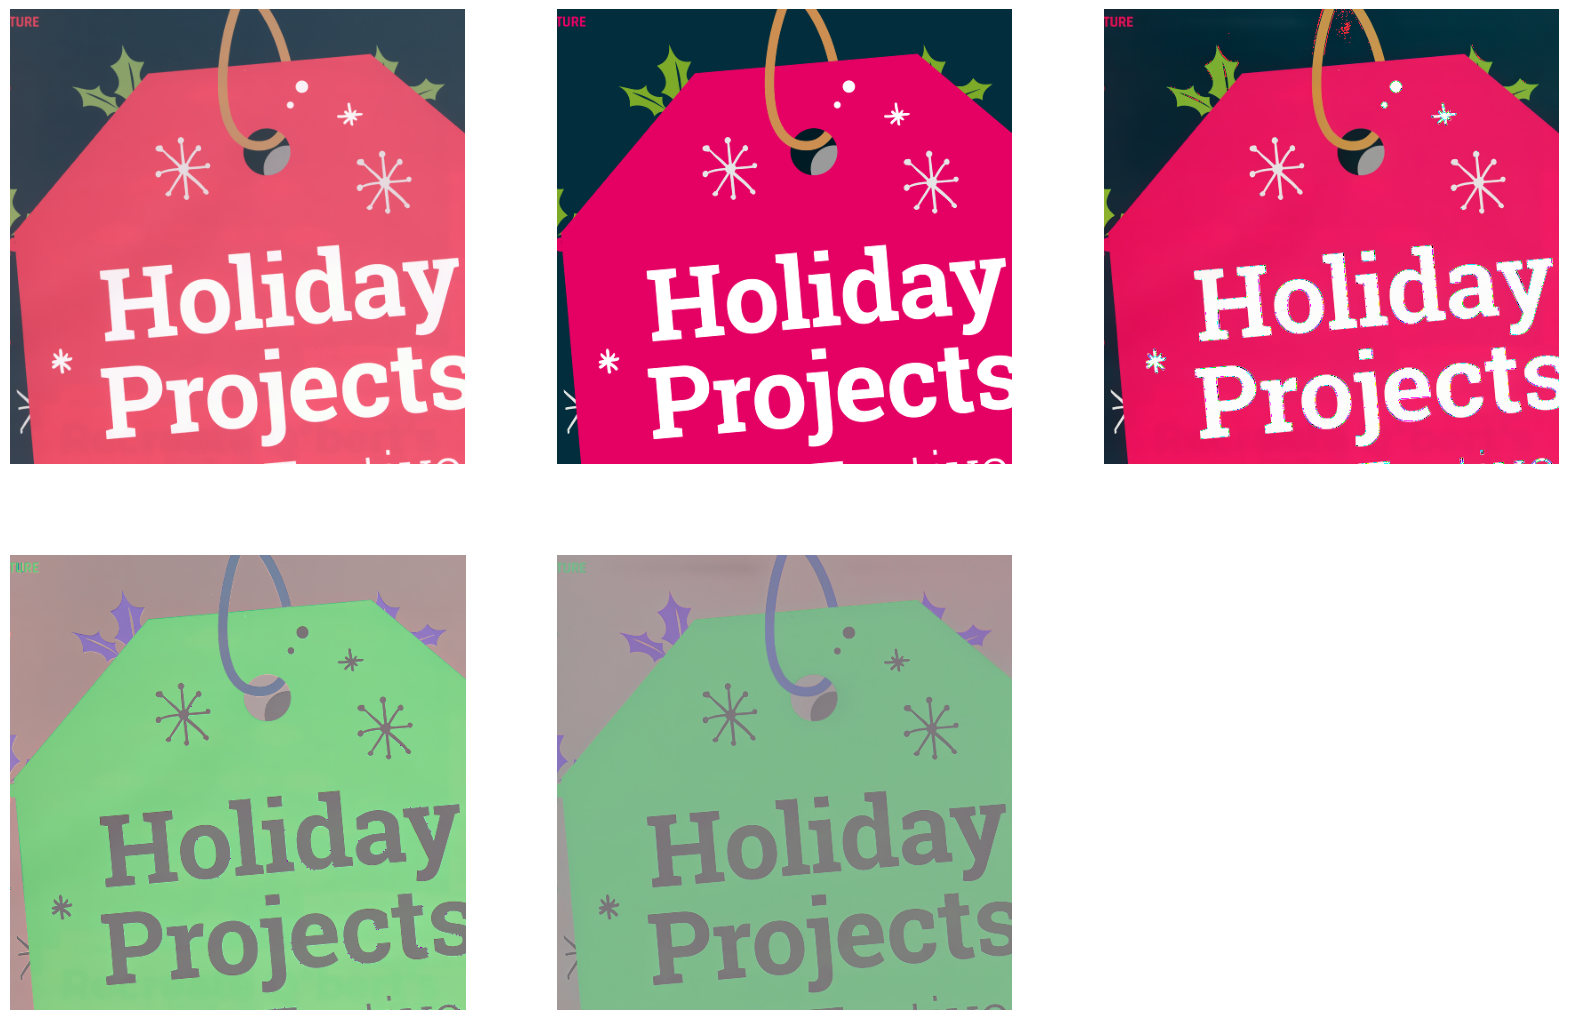

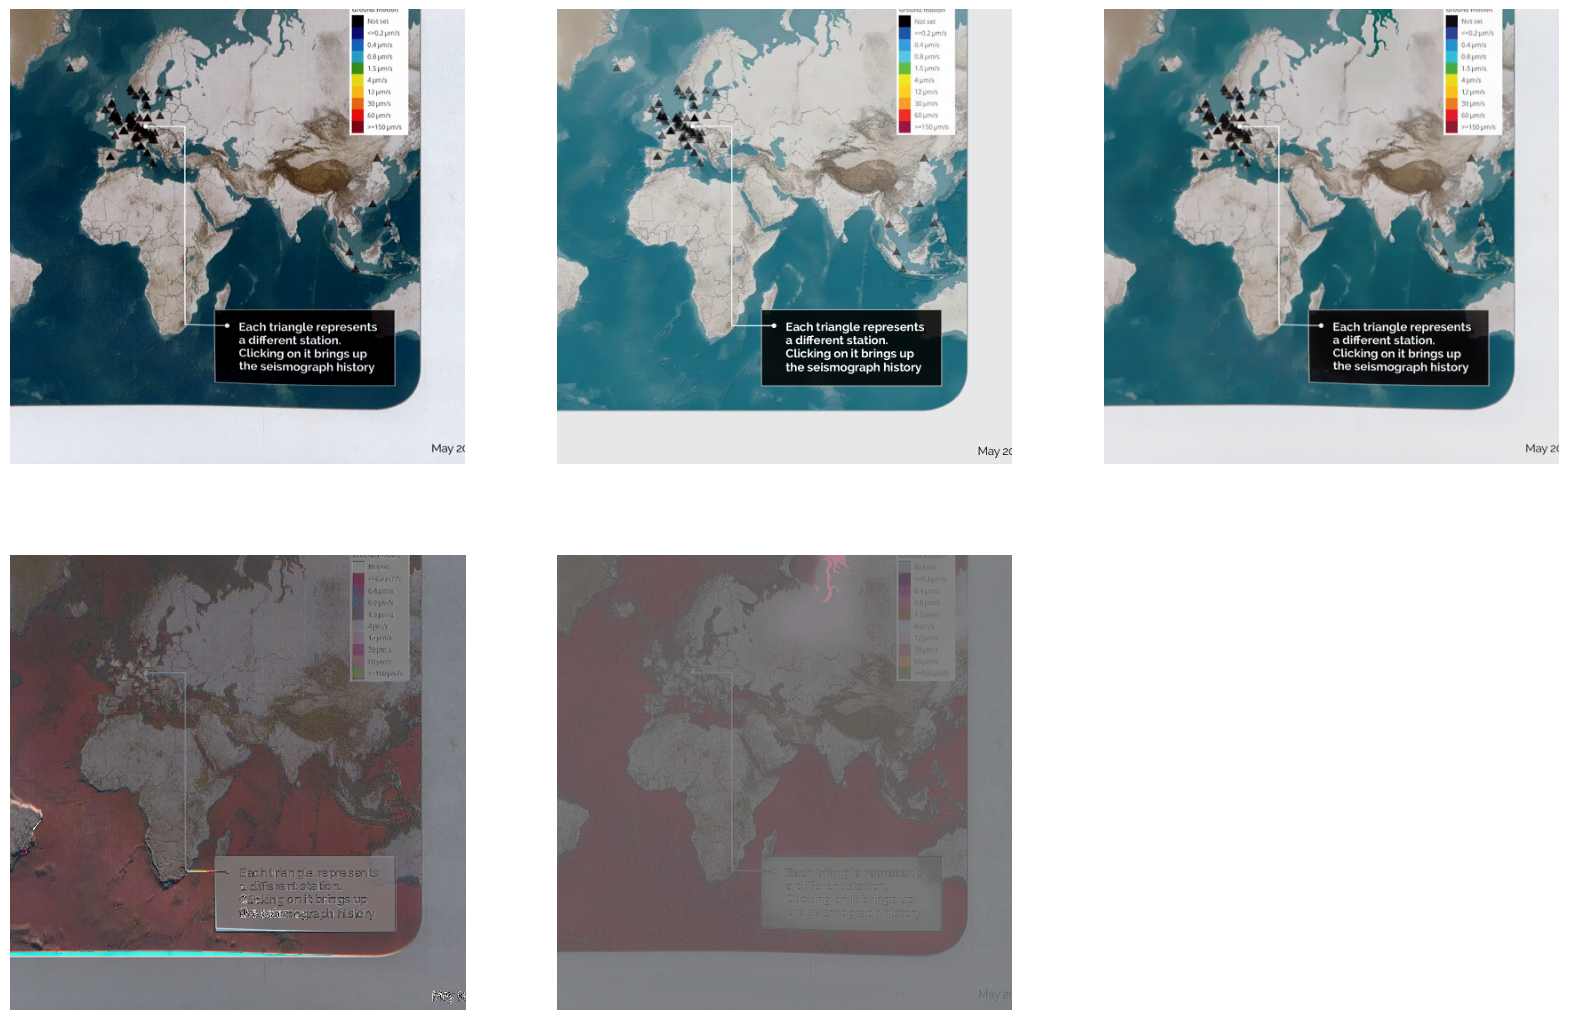

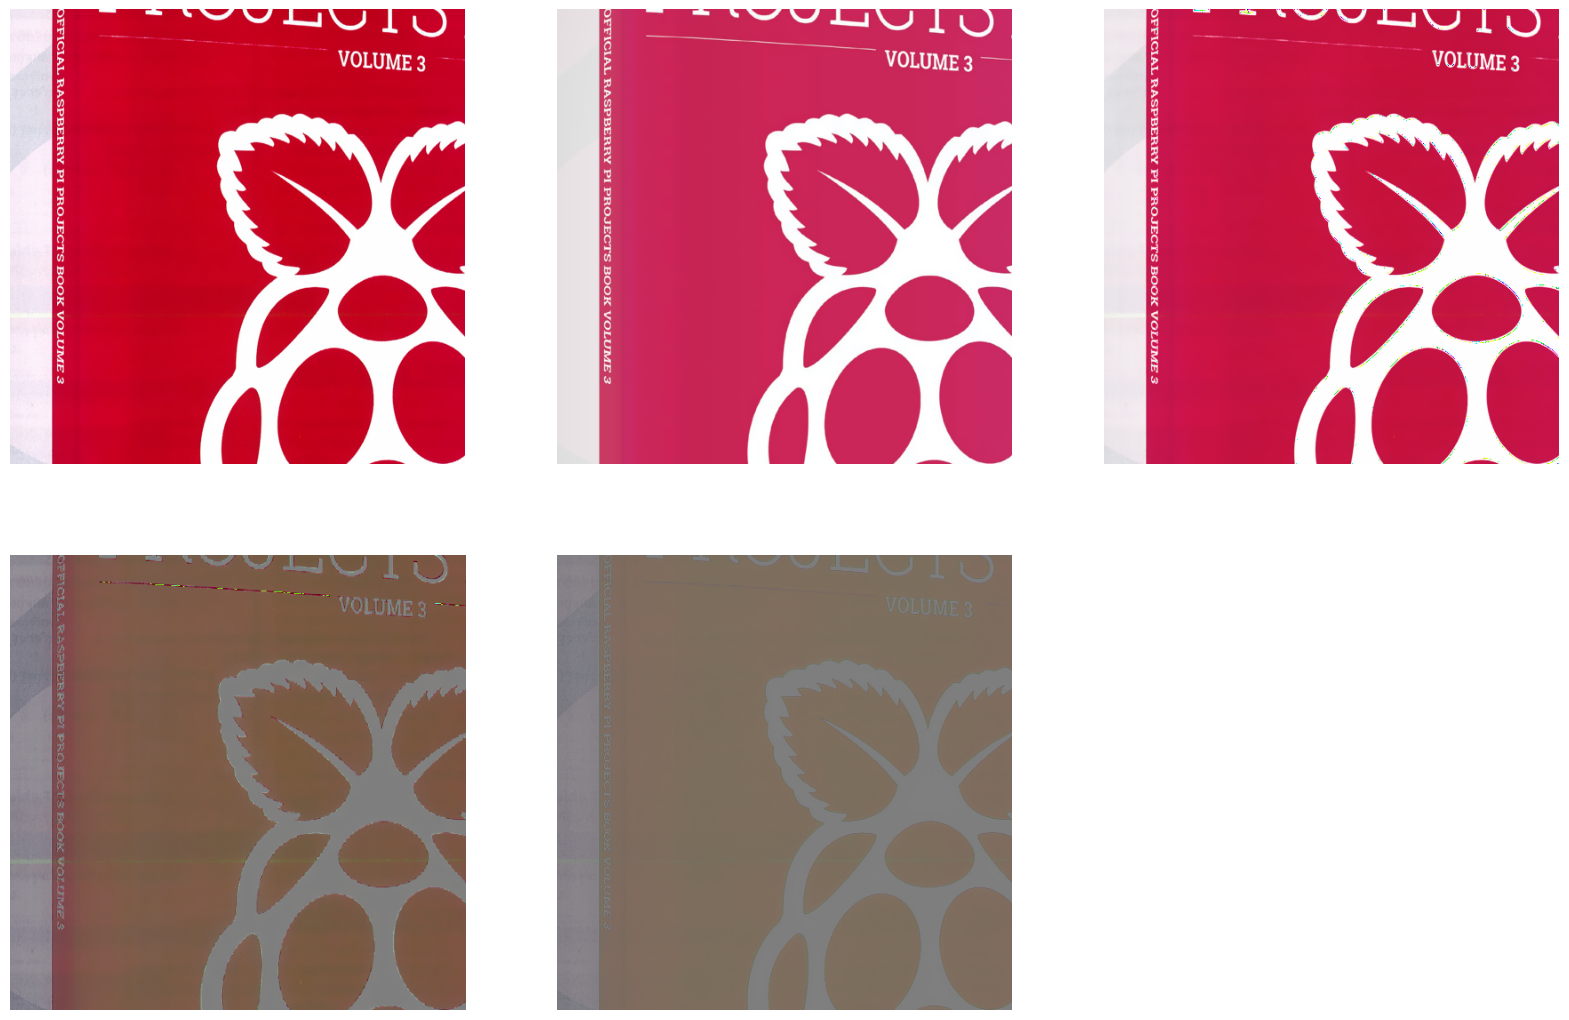

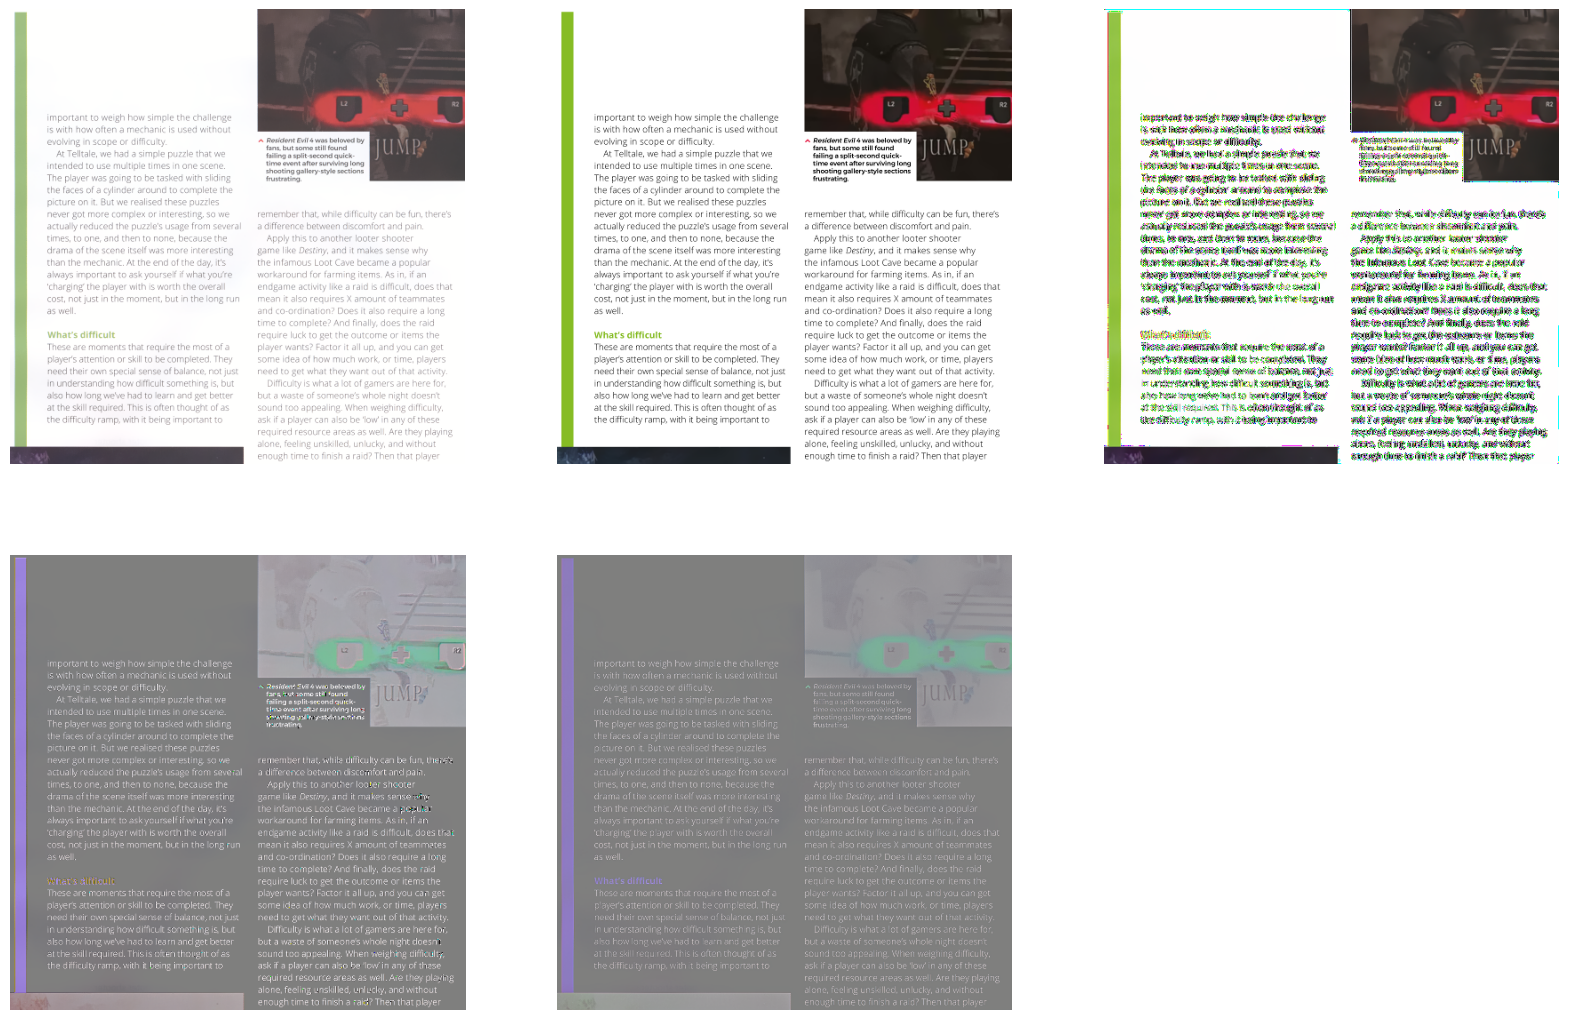

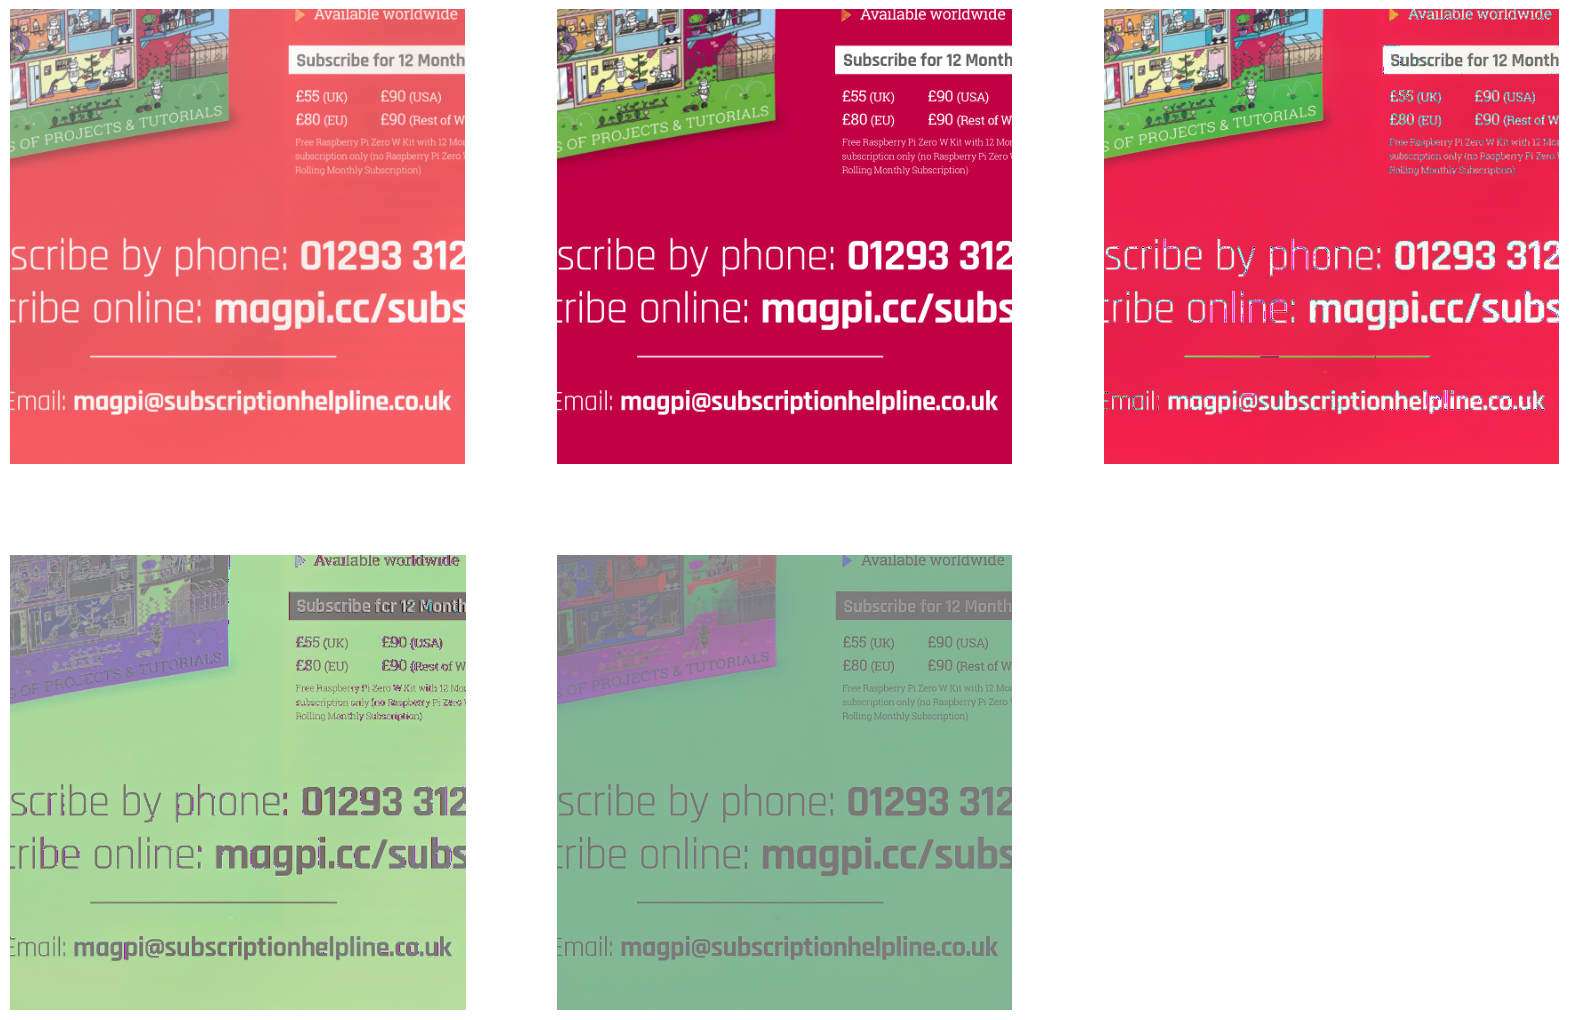

In [17]:
import random
import numpy as np
import cv2
import os
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
from os.path import join
from os import listdir
from torchsummary import summary
import time
import argparse
import models.models.DnCNN as DnCNN, models.models.ResNet as ResNet, models.models.RFDN as RFDN, models.models.DRLN as DRLN
# from models.utils.param import param_check, seed_everything
import models.utils.vgg_loss, models.utils.vgg_perceptual_loss
import matplotlib.pyplot as plt

model_list = ['DnCNN', 'ResNet18', 'RFDN', 'DRLN']

sel_model = model_list[2]
pth_num = 7
noise = True
if noise: pth = '.pth'
else: pth = '_clean.pth' 
pth_dir ='./save/best_'+sel_model+'_model'+str(pth_num)+pth
# load_loss_pth ='./ResNet18_model2.pth'

display_number = 7                               # plt로 디스플레이할 이미지의 개수
residual_output_paths = '/content/residuals'           # 잔차 이미지를 저장할 폴더
noisy_image_paths = '/local_datasets/MLinP/train/scan'
clean_image_paths = '/local_datasets/MLinP/train/clean'

random.seed(3002)
output = False                                         # residual을 파일로 출력할지 여부


def load_img(filepath):
    img = cv2.imread(filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def cvt_to_image(image):
    image = image.cpu().squeeze(0)
     # denoised_image = torch.clamp(denoised_image, 0, 1)  # 이미지 값을 0과 1 사이로 클램핑
    image = ToPILImage()(image*0.5+0.5)
    return image

class CustomDatasetTest(data.Dataset):
    def __init__(self, noisy_image_paths, transform=None):
        self.noisy_image_paths = [join(noisy_image_paths, x) for x in listdir(noisy_image_paths)]
        self.transform = transform

    def __len__(self):
        return len(self.noisy_image_paths)

    def __getitem__(self, index):
        
        noisy_image_path = self.noisy_image_paths[index]
        noisy_image = load_img(self.noisy_image_paths[index])
        
        if self.transform:
            noisy_image = self.transform(noisy_image)

        return noisy_image, noisy_image_path

class BilateralBlur(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self,sample):
        image = sample
        h, w = image.shape[:2]

        return cv2.bilateralFilter(image,-1,10,5)

if sel_model == 'DnCNN':
    model = DnCNN.DnCNN()
elif sel_model == 'ResNet18':
    model = ResNet.ResNet18()
elif sel_model == 'RFDN':
    model = RFDN.RFDN()

device = torch.device('cuda' if torch.cuda.is_available() else 'mps:0' if torch.backends.mps.is_available() else 'cpu')
# device = torch.device('cpu')
model.load_state_dict(torch.load(pth_dir, map_location='cpu'))
model.eval()

# GPU 사용 여부 확인
model.to(device)

test_transform = Compose([
    BilateralBlur(512),
    ToTensor(),
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터셋 로드 및 전처리
noisy_dataset = CustomDatasetTest(noisy_image_paths, transform=test_transform)
clean_dataset = CustomDatasetTest(clean_image_paths, transform=test_transform)

# 데이터 로더 설정
noisy_loader = DataLoader(noisy_dataset, batch_size=1, shuffle=False)
clean_loader = DataLoader(clean_dataset, batch_size=1, shuffle=False)

random_idx = random.sample(range(len(noisy_dataset)), display_number)

# residuals = torch.Tensor(51, 512, 512, 3)
# for i, ((noisy_image, noisy_image_path), (clean_image, clean_image_path) ) in enumerate(zip(noisy_loader,clean_loader)):
#     a=1
for idx in random_idx:
    noisy_image, _ = noisy_dataset.__getitem__(idx)
    clean_image, _ = clean_dataset.__getitem__(idx)
    # residuals[i] = residual_image
    noisy_image = noisy_image.unsqueeze(0).to(device)
    if noise:
        pred_noise = model(noisy_image)
        denoised_image = noisy_image - pred_noise  
    else:
        denoised_image = model(noisy_image)
        pred_noise = noisy_image - denoised_image 
    # denoised_image를 CPU로 이동하여 이미지 저장
    residual_image = noisy_image.cpu() - clean_image.unsqueeze(0)

    denoised_image = cvt_to_image(denoised_image)
    noisy_image = cvt_to_image(noisy_image)
    clean_image = cvt_to_image(clean_image)
    residual_image = cvt_to_image(residual_image)
    pred_noise = cvt_to_image(pred_noise)


    plt.figure(figsize=(20,13))
    plt.subplot(2,3,1)
    plt.imshow(noisy_image)
    plt.axis('off')
    plt.subplot(2,3,2)
    plt.imshow(clean_image)
    plt.axis('off')
    plt.subplot(2,3,3)
    plt.imshow(denoised_image)
    plt.axis('off')
    plt.subplot(2,3,4)
    plt.imshow(residual_image)
    plt.axis('off')
    plt.subplot(2,3,5)
    plt.imshow(pred_noise)
    plt.axis('off')
    plt.show()

# avg_residual = torch.mean(residuals,axis=0)